# Analyzing correlations betweeen variables in data_targets_filter_high_corr

In this notebook, we are going to study the correlations.

* [Setup and loading the data](#setup)
* [Correlation matrix](#corr-matrix)
* [Scatterplot matrix](#scatter-matrix)
* [Detailed analysis between two variables](#two-vars)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [2]:
import dataiku                          # Access to Dataiku datasets
import pandas as pd, numpy as np        # Data manipulation 
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix
import seaborn as sns                   # Graphing
sns.set(style="white")                  # Tuning the style of charts
import warnings                         # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from eda.visualize import *
from eda.filters import *

The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing correlations requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

In [3]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("data_without_high_corr")

# Load the first 100'000 lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(
    limit = 100000)

feat_df = filter_columns(df, filter_method='remove', col_patterns=['.*FUTURE.*'])
targets_df = filter_columns(df, filter_method='keep', col_patterns=['.*FUTURE.*'])



# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 5073
   Columns: 49 (48 num, 0 cat, 1 date)


# Correlation matrix <a id="corr-matrix" />

The very first correlation analysis consists of plotting the "Correlation matrix" for numerical variables.

For each couple of numerical variables, this computes the "strength" of the correlation (called the Pearson coefficient):

 * 1.0 means a perfect correlation
 * 0.0 means no correlation
 * -1.0 means a perfect "inverse" correlation

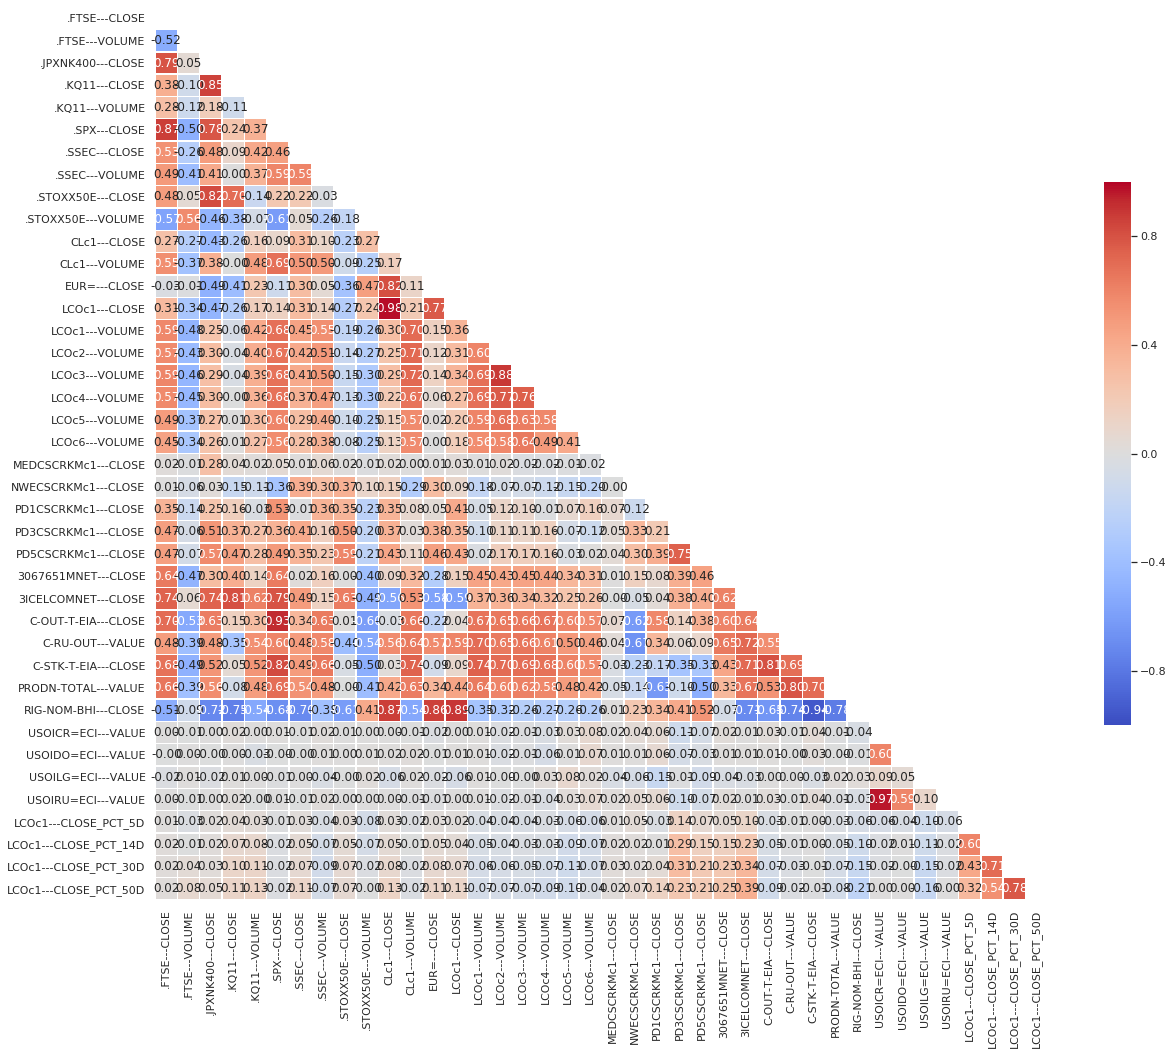

In [4]:
# Only select the requested columns
df_corr_matrix = df[numerical_columns[:]]

# This computes the Pearson coefficient for all couples
corr = feat_df.corr().fillna(0)

# Start drawing

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, vmin=-1, vmax=1, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")

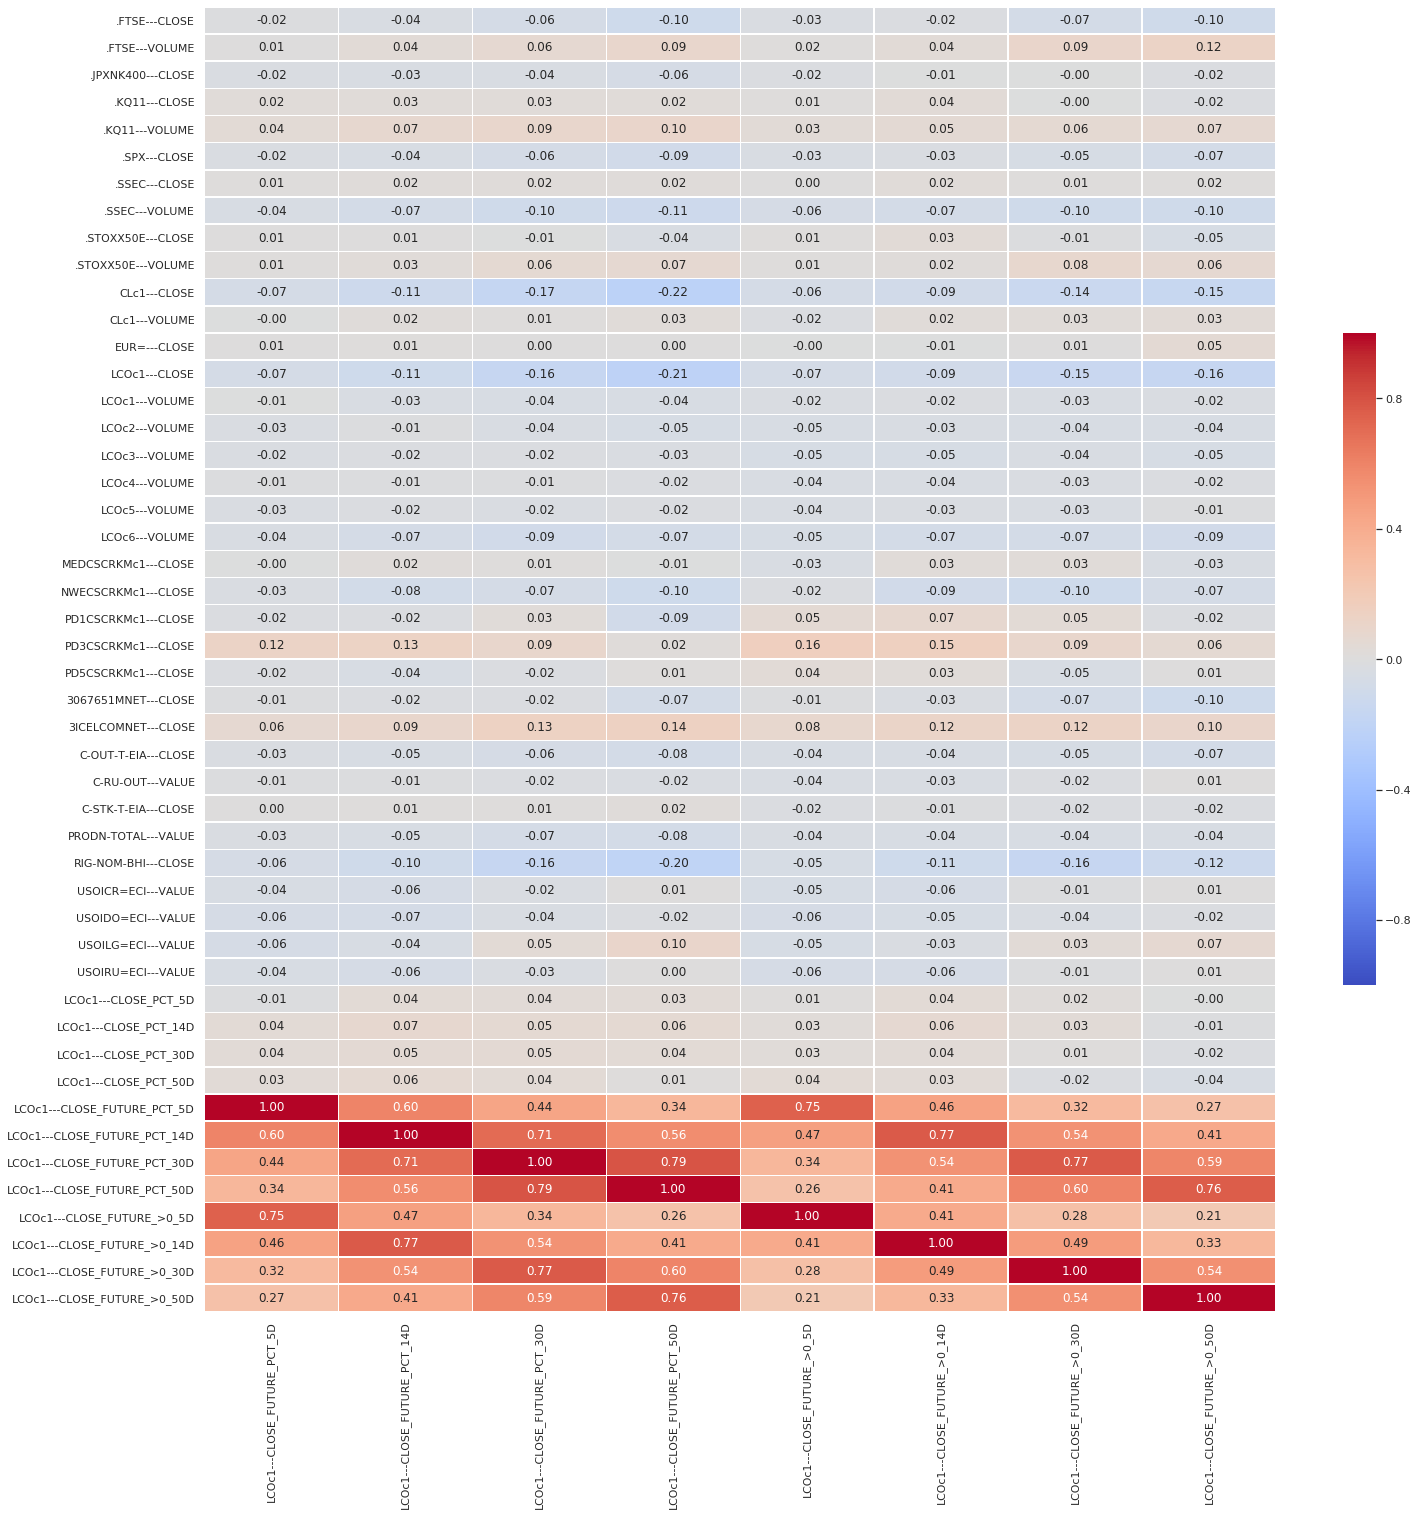

In [5]:
# This computes the Pearson coefficient for all couples
corr = df_corr_matrix.corr().fillna(0)

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

sns.heatmap(corr[targets_df.columns], linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f")

# Scatter matrices <a id="scatter-matrix" />

In [6]:
# Only generate the scatterplot matrix on a sample
df_scatter_samp = df.sample(min(5000, df.shape[0])) # 5000 points maximum on the scatter plot

# Take the first 4 numerical variables to plot the scatterplot matrix
scatter_matrix_vars = [x for x in numerical_columns if 'CLOSE' in x]

# If we have categorical variables, use the categorical variables with the lowest number of modalities
# to plot the points of the scatterplot
scatter_matrix_color = None

cat_cols_with_cards = [(x, df[x].nunique()) for x in categorical_columns]
# We don't want to take a column with only a single modality
# and also we don't want variables with more than 10 modalities (would not really make sense to plot)
cat_cols_with_cards_f = [x for x in cat_cols_with_cards if x[1] >= 2 and x[1] <= 10]

if len(cat_cols_with_cards_f) > 0:
    # We have at least one categorical variable with a good number of modalities, use it
    scatter_matrix_color = sorted(cat_cols_with_cards_f, key= lambda c : c[1])[0][0]
    
print("We will plot the following numerical variables : %s" % scatter_matrix_vars)
if scatter_matrix_color is not None:
    print("Coloring the scatters by: %s" % scatter_matrix_color)

We will plot the following numerical variables : ['.FTSE---CLOSE', '.JPXNK400---CLOSE', '.KQ11---CLOSE', '.SPX---CLOSE', '.SSEC---CLOSE', '.STOXX50E---CLOSE', 'CLc1---CLOSE', 'EUR=---CLOSE', 'LCOc1---CLOSE', 'MEDCSCRKMc1---CLOSE', 'NWECSCRKMc1---CLOSE', 'PD1CSCRKMc1---CLOSE', 'PD3CSCRKMc1---CLOSE', 'PD5CSCRKMc1---CLOSE', '3067651MNET---CLOSE', '3ICELCOMNET---CLOSE', 'C-OUT-T-EIA---CLOSE', 'C-STK-T-EIA---CLOSE', 'RIG-NOM-BHI---CLOSE', 'LCOc1---CLOSE_PCT_5D', 'LCOc1---CLOSE_PCT_14D', 'LCOc1---CLOSE_PCT_30D', 'LCOc1---CLOSE_PCT_50D', 'LCOc1---CLOSE_FUTURE_PCT_5D', 'LCOc1---CLOSE_FUTURE_PCT_14D', 'LCOc1---CLOSE_FUTURE_PCT_30D', 'LCOc1---CLOSE_FUTURE_PCT_50D', 'LCOc1---CLOSE_FUTURE_>0_5D', 'LCOc1---CLOSE_FUTURE_>0_14D', 'LCOc1---CLOSE_FUTURE_>0_30D', 'LCOc1---CLOSE_FUTURE_>0_50D']


In [7]:
# Uncomment this if you want to take manual control over which variables are plotted
# scatter_matrix_vars = ["num1", "num2", "num3"]
# scatter_matrix_color = "cat1"
df.index = df.Date
df['Year'] = df.index.year

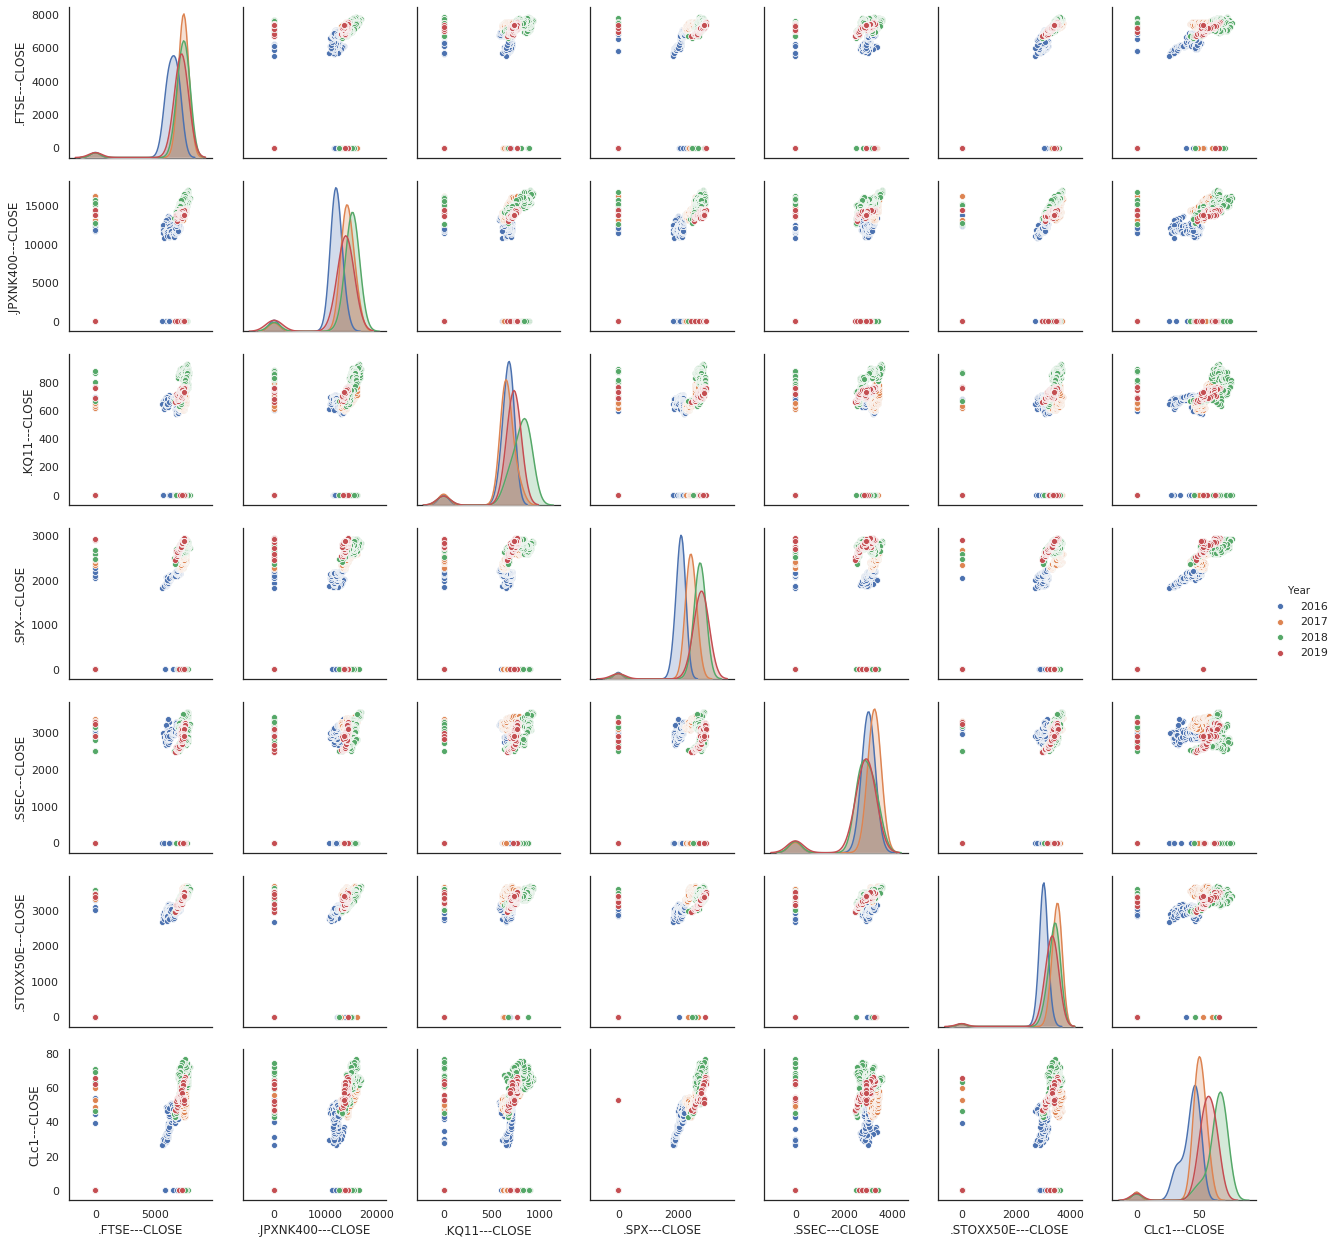

In [8]:
# Seaborn (the graphic library) doesn't like NaNs, so fill the matrix
df_filled = df.fillna(0)
sns.pairplot(df_filled[df_filled['Year']>2016], vars = scatter_matrix_vars[0:7], hue='Year')

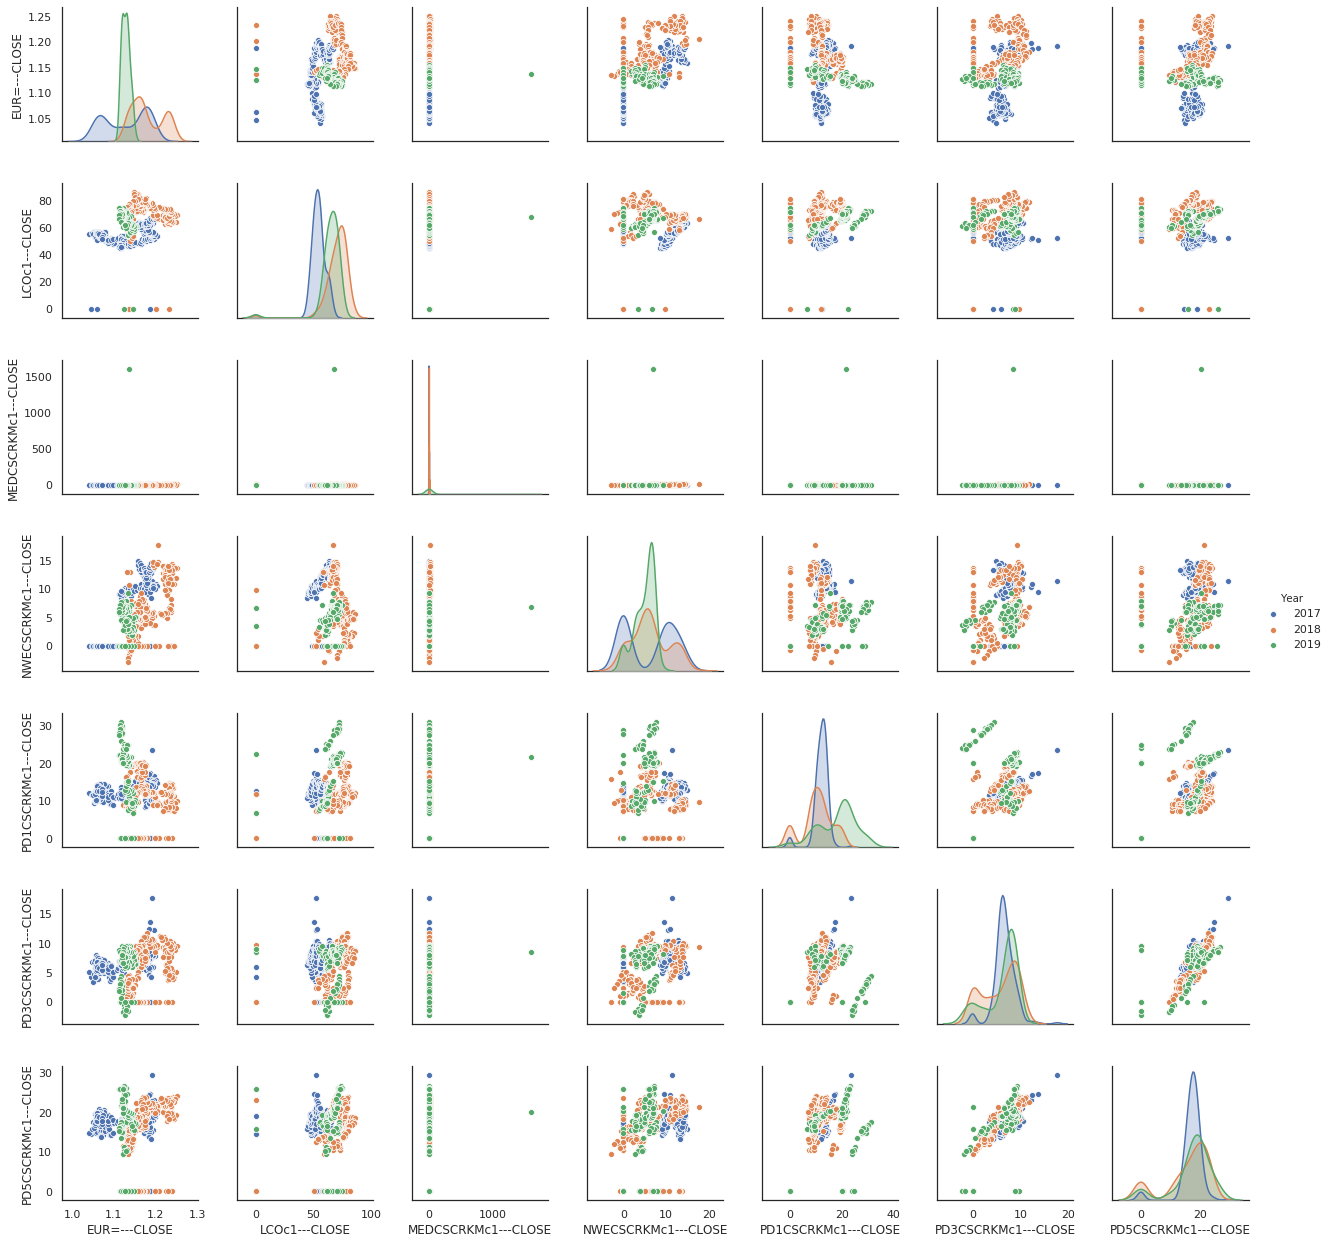

In [9]:
sns.pairplot(df_filled[df_filled['Year']>2016], vars = scatter_matrix_vars[7:14], hue='Year')

### Target correlation

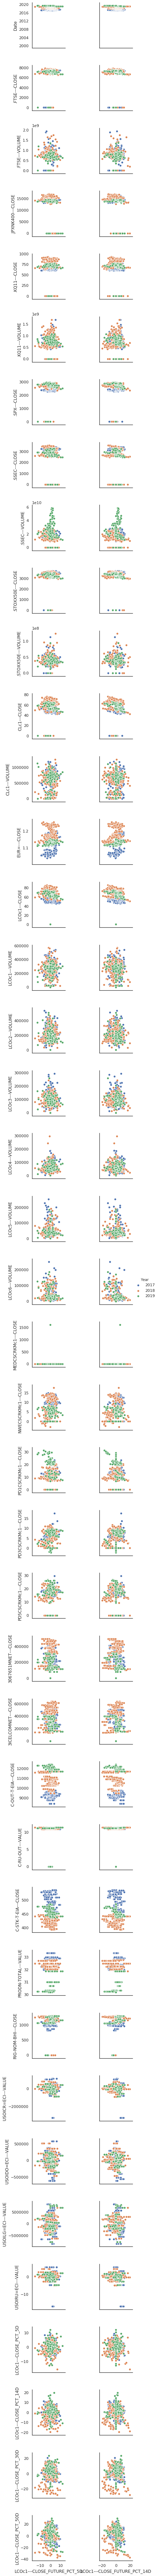

In [15]:
sns.pairplot(df_filled[df_filled['Year']>2016], x_vars = targets_df.columns[0:2], y_vars=feat_df.columns, hue='Year')